In [1]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


## Train baseline model for Amazon dataset

In [21]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/data/Quan/datasets/webcam'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.


In [4]:
def define_block(input_layer, nb_layers, nb_neurons,  kernel_size=(3,3), batch_normalization=True, activation='relu', **kwargs):
    index = None
    if 'index' in kwargs:
        index = kwargs['index']
    
    for i in range(nb_layers):
        if i == 0:
            b = input_layer
            
        b = Conv2D(nb_neurons, kernel_size=kernel_size, strides=1, padding='same', name='conv' + str(i) + '_block' + str(index))(b)
        if batch_normalization:
            b = BatchNormalization(name='batchnorm' + str(i) + '_block' + str(index))(b)
        b =  Activation(activation, name=activation + str(i) + '_block' + str(index))(b)
    b = MaxPooling2D(pool_size=(2,2), name='maxpooling_block' + str(index))(b)
    return b

def define_skipped_connection(src_layer, dst_layer):
    src_shape = src_layer.output_shape
    dst_shape = dst_layer.input_shape
    

def SkippedVGG(nb_blocks, input_shape, num_classes, nb_layers, nb_neurons, include_top=True, verbose=1):
    concats = []
    for i in range(nb_blocks):
        concats.append([])
        
    if type(nb_layers) is int:
        temp = nb_layers
        nb_layers = []
        for i in range(nb_blocks):
            nb_layers.append(temp)
    
    if verbose:
        print('Create DensedVGG model with ' + str(nb_blocks) + ' blocks, input shape = ' + str(input_shape))
    
    for i in range(nb_blocks):
        if verbose:
            print('Create block ' + str(i) + ':')
        
        if i == 0: # First block
            b = Input(shape=input_shape)
            inputs = b
        
        # check all layers before
        if len(concats[i-1]) > 1:
            if verbose:
                print('Concatenate ', concats[i-1])
            b = concatenate(concats[i-1])
            
            # add normalization
            b = BatchNormalization()(b)
            
            
            
        elif len(concats[i-1]) == 1:
            if verbose:
                print('Get direct output from the previous block ', concats[i-1])
            b = concats[i-1][0]
            
        # create main block
        b = define_block(b, nb_layers[i], nb_neurons[i], index=i)
        concats[i].append(b)
        
        # create cropping layer
        for j in range(i+1, nb_blocks):
            if verbose:
                print('-- create skipped connection from block '+ str(i) + ' to block ' + str(j+1) + ' ...')
                
            src_shape = b.get_shape()
            src_shape = (int(src_shape[1]), int(src_shape[2]), int(src_shape[3]))
            dst_shape = (src_shape[0]//2**(j-i), src_shape[1]//2**(j-i), src_shape[2])
            
            print(src_shape, dst_shape)
            h = src_shape[0] - dst_shape[0]
            w = src_shape[1] - dst_shape[1]
            if h % 2 == 0:
                h_0 = h // 2
                h_1 = h // 2
            else:
                h_0 = h // 2
                h_1 = (h // 2) + 1
            
            if w % 2 == 0:
                w_0 = w // 2
                w_1 = w // 2
            else:
                w_0 = w // 2
                w_1 = (w // 2) + 1
                
            concat_layer = Cropping2D(((h_0,h_1),(w_0,w_1)), name='cropping_block' + str(i) + '_block' + str(j+1))(b)
            concats[j].append(concat_layer)
            
    # top model
    if verbose:
        print('Create top model')
        
    if len(concats[nb_blocks-1]) == 1:
        outputs = concats[nb_blocks-1]
    else:
        outputs = concatenate(concats[nb_blocks-1])
    
    outputs = GlobalAveragePooling2D()(outputs)
    # add dropout
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(num_classes)(outputs)
    outputs = BatchNormalization()(outputs)
    outputs = Activation('softmax')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    
    # compile
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    
    if verbose:
        model.summary()
    return model

In [5]:
model = SkippedVGG(nb_blocks=4, input_shape=(300,300,3), num_classes=31, 
                   nb_layers=[2,2,3,3], nb_neurons=[32,64,128,512], include_top=True, verbose=1)

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

W1118 05:13:21.412203 139787051837184 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1118 05:13:21.413231 139787051837184 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1118 05:13:21.416009 139787051837184 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1118 05:13:21.435681 139787051837184 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1118 05:13:21.436187 1397870518

Create DensedVGG model with 4 blocks, input shape = (300, 300, 3)
Create block 0:
-- create skipped connection from block 0 to block 2 ...
(150, 150, 32) (75, 75, 32)
-- create skipped connection from block 0 to block 3 ...
(150, 150, 32) (37, 37, 32)
-- create skipped connection from block 0 to block 4 ...
(150, 150, 32) (18, 18, 32)
Create block 1:
Get direct output from the previous block  [<tf.Tensor 'maxpooling_block0/MaxPool:0' shape=(?, 150, 150, 32) dtype=float32>]
-- create skipped connection from block 1 to block 3 ...
(75, 75, 64) (37, 37, 64)
-- create skipped connection from block 1 to block 4 ...
(75, 75, 64) (18, 18, 64)
Create block 2:
Concatenate  [<tf.Tensor 'cropping_block0_block2/strided_slice:0' shape=(?, 75, 75, 32) dtype=float32>, <tf.Tensor 'maxpooling_block1/MaxPool:0' shape=(?, 75, 75, 64) dtype=float32>]
-- create skipped connection from block 2 to block 4 ...
(37, 37, 128) (18, 18, 128)
Create block 3:
Concatenate  [<tf.Tensor 'cropping_block0_block3/strided

W1118 05:13:22.245797 139787051837184 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1118 05:13:22.331394 139787051837184 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Create top model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
____________________________________________________________________________________________

In [6]:
import pickle

epochs = 60

mcp = ModelCheckpoint('/data/Quan/tf_models/amazon/baseline_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames)//batch_size, 
                            epochs=epochs, verbose=1, validation_data=validation_generator, 
                              validation_steps=len(validation_generator.filenames)//batch_size, callbacks=[mcp])

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/baseline_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

W1118 05:13:22.461971 139787051837184 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/60
49/49 [==============================] - 25s 506ms/step - loss: 3.1855 - acc: 0.1320 - val_loss: 8.8175 - val_acc: 0.0547
Epoch 2/60
49/49 [==============================] - 20s 418ms/step - loss: 2.8288 - acc: 0.2010 - val_loss: 3.0285 - val_acc: 0.1983
Epoch 3/60
49/49 [==============================] - 18s 375ms/step - loss: 2.6586 - acc: 0.2608 - val_loss: 2.9243 - val_acc: 0.1460
Epoch 4/60
49/49 [==============================] - 18s 374ms/step - loss: 2.5287 - acc: 0.3080 - val_loss: 3.6644 - val_acc: 0.1763
Epoch 5/60
49/49 [==============================] - 18s 374ms/step - loss: 2.4468 - acc: 0.3451 - val_loss: 3.9420 - val_acc: 0.1570
Epoch 6/60
49/49 [==============================] - 18s 375ms/step - loss: 2.3238 - acc: 0.3859 - val_loss: 3.0935 - val_acc: 0.1570
Epoch 7/60
49/49 [==============================] - 18s 375ms/step - loss: 2.2142 - acc: 0.4254 - val_loss: 2.9734 - val_acc: 0.1322
Epoch 8/60
49/49 [==============================] - 18s 376ms/step - 

In [7]:
import pickle

epochs = 60

mcp = ModelCheckpoint('/data/Quan/tf_models/amazon/baseline_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history_2 = model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames)//batch_size, 
                            epochs=epochs, verbose=1, validation_data=validation_generator, 
                              validation_steps=len(validation_generator.filenames)//batch_size, callbacks=[mcp])

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/baseline_history_2.hdf5', 'wb') as dt:
    pickle.dump(history_2.history, dt)

Epoch 1/60
49/49 [==============================] - 18s 376ms/step - loss: 0.3556 - acc: 0.9356 - val_loss: 2.3225 - val_acc: 0.4435
Epoch 2/60
49/49 [==============================] - 19s 379ms/step - loss: 0.3455 - acc: 0.9337 - val_loss: 2.0879 - val_acc: 0.4986
Epoch 3/60
49/49 [==============================] - 18s 374ms/step - loss: 0.3571 - acc: 0.9420 - val_loss: 2.0084 - val_acc: 0.4683
Epoch 4/60
49/49 [==============================] - 18s 376ms/step - loss: 0.3696 - acc: 0.9337 - val_loss: 3.2353 - val_acc: 0.3411
Epoch 5/60
49/49 [==============================] - 18s 375ms/step - loss: 0.3564 - acc: 0.9358 - val_loss: 2.2665 - val_acc: 0.4490
Epoch 6/60
49/49 [==============================] - 18s 375ms/step - loss: 0.3369 - acc: 0.9407 - val_loss: 1.8767 - val_acc: 0.5730
Epoch 7/60
49/49 [==============================] - 18s 376ms/step - loss: 0.3777 - acc: 0.9280 - val_loss: 1.8174 - val_acc: 0.5234
Epoch 8/60
49/49 [==============================] - 18s 375ms/step - 

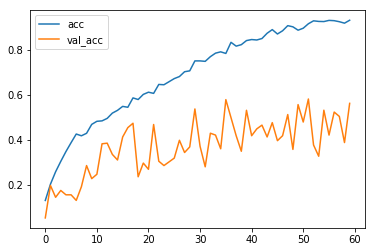

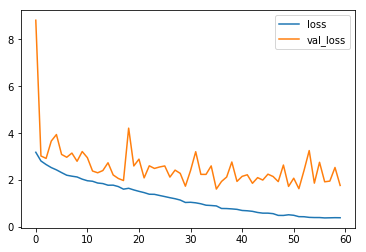

In [8]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

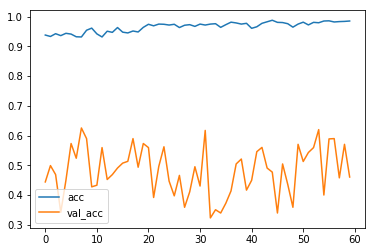

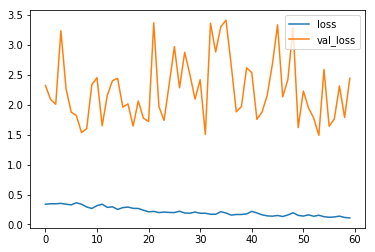

In [9]:
%matplotlib inline
plt.plot(history_2.history['acc'], label='acc')
plt.plot(history_2.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history_2.history['loss'], label='loss')
plt.plot(history_2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [4]:
from keras.models import *
test_model = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
test_model.summary()

W1122 03:28:49.573322 140393925924608 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1122 03:28:49.580658 140393925924608 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1122 03:28:49.600354 140393925924608 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1122 03:28:49.600835 140393925924608 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1122 03:28:49.601285 140393925

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

In [5]:
test_model.evaluate_generator(test_generator, steps=len(test_generator.filenames), verbose=1)

846/846 [==============================] - 8s 9ms/step


[1.5177618196109364, 0.624113475177305]

In [16]:
os.mkdir('/data/Quan/datasets/webcam/val_images/desktop_computer')

## Train baseline model for Webcam dataset

In [33]:
model = SkippedVGG(nb_blocks=4, input_shape=(300,300,3), num_classes=31, 
                   nb_layers=[2,2,3,3], nb_neurons=[32,64,128,512], include_top=True, verbose=1)

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

Create DensedVGG model with 4 blocks, input shape = (300, 300, 3)
Create block 0:
-- create skipped connection from block 0 to block 2 ...
(150, 150, 32) (75, 75, 32)
-- create skipped connection from block 0 to block 3 ...
(150, 150, 32) (37, 37, 32)
-- create skipped connection from block 0 to block 4 ...
(150, 150, 32) (18, 18, 32)
Create block 1:
Get direct output from the previous block  [<tf.Tensor 'maxpooling_block0_3/MaxPool:0' shape=(?, 150, 150, 32) dtype=float32>]
-- create skipped connection from block 1 to block 3 ...
(75, 75, 64) (37, 37, 64)
-- create skipped connection from block 1 to block 4 ...
(75, 75, 64) (18, 18, 64)
Create block 2:
Concatenate  [<tf.Tensor 'cropping_block0_block2_3/strided_slice:0' shape=(?, 75, 75, 32) dtype=float32>, <tf.Tensor 'maxpooling_block1_3/MaxPool:0' shape=(?, 75, 75, 64) dtype=float32>]
-- create skipped connection from block 2 to block 4 ...
(37, 37, 128) (18, 18, 128)
Create block 3:
Concatenate  [<tf.Tensor 'cropping_block0_block3_3

In [35]:
import pickle

epochs = 60

mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/baseline_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames)//batch_size, 
                            epochs=epochs, verbose=1, validation_data=validation_generator, 
                              validation_steps=len(validation_generator.filenames)//batch_size, callbacks=[mcp])

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/baseline_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

Epoch 1/60
13/13 [==============================] - 11s 816ms/step - loss: 3.0023 - acc: 0.1803 - val_loss: 4.4229 - val_acc: 0.1042
Epoch 2/60
13/13 [==============================] - 6s 499ms/step - loss: 2.3994 - acc: 0.3363 - val_loss: 3.9902 - val_acc: 0.1375
Epoch 3/60
13/13 [==============================] - 5s 368ms/step - loss: 2.1888 - acc: 0.4322 - val_loss: 4.7269 - val_acc: 0.1375
Epoch 4/60
13/13 [==============================] - 5s 368ms/step - loss: 2.1004 - acc: 0.4344 - val_loss: 4.1780 - val_acc: 0.1000
Epoch 5/60
13/13 [==============================] - 5s 373ms/step - loss: 1.9729 - acc: 0.5322 - val_loss: 3.1125 - val_acc: 0.1667
Epoch 6/60
13/13 [==============================] - 5s 371ms/step - loss: 1.8563 - acc: 0.5247 - val_loss: 2.0239 - val_acc: 0.3875
Epoch 7/60
13/13 [==============================] - 5s 369ms/step - loss: 1.7529 - acc: 0.5917 - val_loss: 2.3667 - val_acc: 0.3875
Epoch 8/60
13/13 [==============================] - 5s 369ms/step - loss: 1

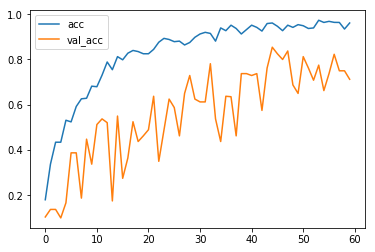

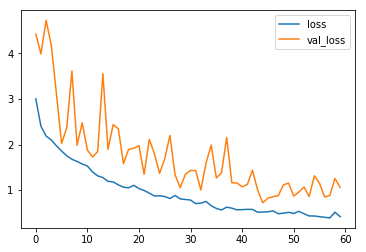

In [36]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [37]:
test_model = load_model('/data/Quan/tf_models/webcam/baseline_model.hdf5')
test_model.evaluate_generator(test_generator, steps=len(test_generator.filenames), verbose=1)

239/239 [==============================] - 3s 11ms/step


[1.1620451616051228, 0.7322175732217573]

In [39]:
# Test on Amazon dataset
test_model.evaluate_generator(test_generator, steps=len(test_generator.filenames), verbose=1)

846/846 [==============================] - 6s 8ms/step


[5.280433841630699, 0.08747044917257683]

## Test Amazon model on Webcam dataset

In [34]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/data/Quan/datasets/webcam'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.


In [7]:
test_model.evaluate_generator(test_generator, steps=len(test_generator.filenames), verbose=1)

239/239 [==============================] - 2s 8ms/step


[3.7955281758451034, 0.11715481171548117]

## Using Amazon model as extractor

In [26]:
extractor = Model(inputs=test_model.input, outputs=test_model.layers[-6].output)
extractor.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

In [27]:
for layer in extractor.layers:
    layer.trainable = False

In [28]:
input_model = Input(shape=(300,300,3))
x = extractor(input_model)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

model = Model(input_model, x)
model.compile(loss=categorical_crossentropy, optimizer=Adam(0.0005), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
model_6 (Model)              (None, 18, 18, 736)       6233504   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 736)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 31)                22847     
_________________________________________________________________
batch_normalization_4 (Batch (None, 31)                124       
_________________________________________________________________
activation_4 (Activation)    (None, 31)                0         
Total para

In [29]:
import pickle

epochs = 50

mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_extractor_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator.filenames)//batch_size, 
                            epochs=epochs, verbose=1, validation_data=validation_generator, 
                              validation_steps=len(validation_generator.filenames)//batch_size, callbacks=[mcp])

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/amazon_extractor_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

Epoch 1/50
13/13 [==============================] - 4s 280ms/step - loss: 3.7996 - acc: 0.0505 - val_loss: 3.3698 - val_acc: 0.0729
Epoch 2/50
13/13 [==============================] - 2s 162ms/step - loss: 3.5981 - acc: 0.0529 - val_loss: 3.2720 - val_acc: 0.1125
Epoch 3/50
13/13 [==============================] - 3s 221ms/step - loss: 3.2882 - acc: 0.1209 - val_loss: 3.0720 - val_acc: 0.1625
Epoch 4/50
13/13 [==============================] - 3s 221ms/step - loss: 3.0828 - acc: 0.1288 - val_loss: 3.1161 - val_acc: 0.2375
Epoch 5/50
13/13 [==============================] - 3s 231ms/step - loss: 2.9080 - acc: 0.1724 - val_loss: 2.9546 - val_acc: 0.2917
Epoch 6/50
13/13 [==============================] - 3s 216ms/step - loss: 2.9180 - acc: 0.1947 - val_loss: 2.9836 - val_acc: 0.2500
Epoch 7/50
13/13 [==============================] - 3s 219ms/step - loss: 2.8254 - acc: 0.2226 - val_loss: 2.7496 - val_acc: 0.3250
Epoch 8/50
13/13 [==============================] - 3s 226ms/step - loss: 2.

In [31]:
test_model = load_model('/data/Quan/tf_models/webcam/amazon_extractor_model.hdf5')
test_model.evaluate_generator(test_generator, steps=len(test_generator.filenames), verbose=1)

239/239 [==============================] - 2s 10ms/step


[2.3910680869009706, 0.4602510460251046]

## Combine representation and with source labels

In [37]:
amazon_model = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')

pretrain_model = Model(amazon_model.input, amazon_model.layers[-5].output)
for layer in pretrain_model.layers:
    layer.trainable = False

t_model = Model(amazon_model.input, amazon_model.layers[-5].output)

In [78]:
average_layer = Lambda(lambda x: K.sum(x[0],x[1]))

In [70]:
np.mean([a,b], axis=0)

array([0.6267754 , 0.4367618 , 0.36767385, 0.60826076, 0.83427913,
       0.57496044, 0.8053328 , 0.27433997, 0.39576645, 0.7659917 ,
       0.62015488, 0.4324175 , 0.31955333, 0.37435127, 0.30462354])

In [38]:
# s_input = Input(shape=(300,300,3))
t_input = Input(shape=(300,300,3))

# s_features = pretrain_model(s_input)
t_features = t_model(t_input)

# x = concatenate([s_features, t_features])
x = Dense(736)(x)
x = Reshape((4,4,46))(x)

x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

model = Model([s_input, t_input], x)
model.compile(loss=categorical_crossentropy, optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 736)          6233504     input_3[0][0]                    
__________________________________________________________________________________________________
model_5 (Model)                 (None, 736)          6233504     input_4[0][0]                    
__________________________________________________________________________________________________
concatenat

In [50]:
import numpy as np
import keras
from skimage.io import imread
from skimage import *

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(300,300), n_channels=3,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def preprocess(self,img):
        return img_as_float64(img)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs[0]) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        s_indexes = self.s_indexes[index*self.batch_size : (index+1)*self.batch_size]
        t_indexes = self.t_indexes[index*self.batch_size : (index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = []
        list_IDs_temp.append([self.list_IDs[0][k] for k in s_indexes])
        list_IDs_temp.append([self.list_IDs[1][k] for k in t_indexes])
        
        # Find list of labels
        list_labels_temp = [self.labels[k] for k in t_indexes]
#         list_labels_temp.append([self.labels[1][k] for k in t_indexes])
        

        # Generate data
        X_s, X_t, y = self.__data_generation(list_IDs_temp, list_labels_temp)

        return [X_s, X_t], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.s_indexes = np.arange(len(self.list_IDs[0]))
        self.t_indexes = np.arange(len(self.list_IDs[1]))
        if self.shuffle == True:
            np.random.shuffle(self.s_indexes)
            np.random.shuffle(self.t_indexes)

    def __data_generation(self, list_IDs_temp, list_labels_temp):
        'Generates data containing batch_size samples' 
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X_s = np.empty((self.batch_size, *self.dim, self.n_channels), dtype='float')
        X_t = np.empty((self.batch_size, *self.dim, self.n_channels), dtype='float')
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp[0]):
            # Store sample
            X_s[i,] = imread(ID)
            X_s[i,] = self.preprocess(X_s[i,])
            
            
        # Generate data
        for i, ID in enumerate(list_IDs_temp[1]):
            # Store sample
            temp_img = imread(ID)
            X_t[i,] = transform.resize(temp_img,(300,300))
            X_t[i,] = self.preprocess(X_t[i,])
            # Store class
            y[i] = list_labels_temp[i]

        return X_s, X_t, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [42]:
from sklearn.model_selection import train_test_split

def get_data(directory):
    sub_folders = os.listdir(directory)
    sub_folders = [os.path.join(directory,k) for k in sub_folders]
    
    img_paths = []
    labels = []
    
    for f_i, folder in enumerate(sub_folders):
        paths = os.listdir(folder)
        paths = [os.path.join(folder,k) for k in paths]

        for p in paths:
            img_paths.append(p)
            labels.append(f_i)
   
    return img_paths, labels

# train_paths, test_paths, train_labels, test_labels = splitting('/data/Quan/datasets/amazon/images')

In [43]:
# Train data
s_img_paths, _ = get_data('/data/Quan/datasets/amazon/images')
t_img_paths, labels = get_data('/data/Quan/datasets/webcam/images')

list_IDs = [s_img_paths, t_img_paths]

In [44]:
#Validation data

sval_img_paths, _ = get_data('/data/Quan/datasets/amazon/val_images')
tval_img_paths, val_labels = get_data('/data/Quan/datasets/webcam/val_images')

list_val_IDs = [sval_img_paths, tval_img_paths]

In [51]:
#Define generator
train_generator = DataGenerator(list_IDs, labels, batch_size=8, dim=(300,300), 
                                n_channels=3, n_classes=31, shuffle=True)

validation_generator = DataGenerator(list_val_IDs, val_labels, batch_size=8, dim=(300,300),
                                    n_channels=3, n_classes=31, shuffle=False)

In [52]:
import pickle

epochs = 50

mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/combine_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = model.fit_generator(train_generator, epochs=epochs, verbose=1, 
                              validation_data=validation_generator, callbacks=[mcp])

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/combine_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

Epoch 1/50
197/197 [==============================] - 20s 104ms/step - loss: 3.5947 - acc: 0.0615 - val_loss: 14.5967 - val_acc: 0.0944
Epoch 2/50
 18/197 [=>............................] - ETA: 13s - loss: 3.4288 - acc: 0.0347

IndexError: index 4534561874808668160 is out of bounds for axis 1 with size 31

In [5]:
from sklearn.model_selection import train_test_split

def splitting(directory, test_size):
    sub_folders = os.listdir(directory)
    sub_folders = [os.path.join(directory,k) for k in sub_folders]
    
    img_paths = []
    labels = []
    
    for folder in sub_folders:
        paths = os.listdir(folder)
        paths = [os.path.join(folder,k) for k in paths]

        for p in paths:
            img_paths.append(p)
            labels.append(os.path.basename(folder))
    
    train_paths, test_paths, train_labels, test_labels = train_test_split(img_paths, labels, 
                                                                      test_size=test_size, 
                                                                      random_state=42)
    return train_paths, test_paths, train_labels, test_labels

# train_paths, test_paths, train_labels, test_labels = splitting('/data/Quan/datasets/amazon/images')

In [8]:
train_paths, test_paths, train_labels, test_labels = splitting('/data/Quan/datasets/webcam/images', 0.2)

## Learning to map from T features to S features

In [10]:
input_model = Input(shape=(18,18,736))

x = Flatten()(input_model)
# x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)

x = Dense(32, activation='relu')(x)
x = Dense(128, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
x = Dense(18*18*736, activation='relu')(x)

x = Reshape((18,18,736))(x)

encoder_model = Model(input_model, x)
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 238464)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               30523520  
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_10 (Dense)             (None, 238464)            30761856  
__________

### Define loss (MSE)

In [11]:
encoder_model.compile(loss='mse', optimizer=Adam(), metrics=['mse'])

### Get extracted features from destination images

In [10]:
amazon = load_model('/data/Quan/tf_models/webcam/baseline_model.hdf5')

In [12]:
pretrain_amazon = Model(amazon.input, amazon.layers[-6].output)

for layer in pretrain_amazon.layers:
    layer.trainable = False

In [34]:
def get_image_paths(directory):
    sub_folders = os.listdir(directory)
    sub_folders = [os.path.join(directory, k) for k in sub_folders]
    
    image_paths = []
    for folder in sub_folders:
        paths = os.listdir(folder)
        paths = [os.path.join(folder,k) for k in paths]
#         print(paths)
        for p in paths:
            image_paths.append(p)
    return image_paths

#### target domain

In [72]:
val_webcam_paths = get_image_paths('/data/Quan/datasets/webcam/val_images')
len(val_webcam_paths)

112

In [73]:
val_webcam_images = np.empty((112,300,300,3))

for i,p in enumerate(val_webcam_paths):
    val_webcam_images[i,:,:,:] = resize(imread(p), (300,300))
    
val_webcam_images.shape

(112, 300, 300, 3)

In [74]:
# extract feature
t_val_features = pretrain_amazon.predict(val_webcam_images, verbose=1)
t_val_features.shape

112/112 [==============================] - 1s 13ms/step


(112, 18, 18, 736)

In [76]:
# save features
with open('/data/Quan/tf_models/webcam/val_extracted_features.hdf5', 'wb') as dt:
    pickle.dump([val_webcam_paths, t_val_features], dt)

#### source domain

In [77]:
val_amazon_paths = get_image_paths('/data/Quan/datasets/amazon/val_images')
len(val_amazon_paths)

395

In [78]:
val_amazon_images = np.empty((395,300,300,3))

for i,p in enumerate(val_amazon_paths):
    val_amazon_images[i,:,:,:] = resize(imread(p), (300,300))
    
val_amazon_images.shape

(395, 300, 300, 3)

In [79]:
# extract feature

s_val_features = pretrain_amazon.predict(val_amazon_images, verbose=1)
s_val_features.shape

395/395 [==============================] - 3s 7ms/step


(395, 18, 18, 736)

In [80]:
# save features
with open('/data/Quan/tf_models/amazon/val_extracted_features.hdf5', 'wb') as dt:
    pickle.dump([val_amazon_paths, s_val_features], dt)

In [6]:
def get_features(directory):
    with open(directory, 'rb') as dt:
        data = pickle.load(dt)
        paths = data[0]
        features = data[1]

        labels = np.array([k.split('/')[-2] for k in paths])
    
    return features, labels

t_features, webcam_labels = get_features('/data/Quan/tf_models/webcam/extracted_features.hdf5')
t_val_features, val_webcam_labels = get_features('/data/Quan/tf_models/webcam/val_extracted_features.hdf5')

s_features, amazon_labels = get_features('/data/Quan/tf_models/amazon/extracted_features.hdf5')
s_val_features, val_amazon_labels = get_features('/data/Quan/tf_models/amazon/val_extracted_features.hdf5')


### Train mapping model (without labels)

In [12]:
import numpy as np
import keras
from skimage.io import imread
from skimage import *

class FeatureDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_t_features, list_t_labels, list_s_features, list_s_labels, 
                 batch_size=32, dim=(300,300), n_channels=3,
                 n_classes=10, shuffle=True):
        
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        
        self.list_t_features = list_t_features
        self.list_t_labels = list_t_labels
        self.list_s_features = list_s_features
        self.list_s_labels = list_s_labels
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def preprocess(self,img):
        pass

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_t_features) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_t_features[k] for k in indexes]
        list_labels_temp = [self.list_t_labels[k] for k in indexes]
        
        # Generate data
        X_t, X_s = self.__data_generation(list_IDs_temp, list_labels_temp)

        return X_t, X_s

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_t_features))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp, list_labels_temp):
        'Generates data containing batch_size samples' 
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X_t = np.empty((self.batch_size, *self.dim, self.n_channels), dtype='float')
        X_s = np.empty((self.batch_size, *self.dim, self.n_channels), dtype='float')
        
        temp_X_s = []
        
        t_labels, n_labels = np.unique(list_labels_temp, return_counts=True)
        
        for i,lb in enumerate(t_labels):
            indices = np.where(self.list_s_labels==lb)[0][:n_labels[i]]
            temp_X_s.append([self.list_s_features[k] for k in indices])
        
        for i,feature in enumerate(list_IDs_temp):
            X_t[i,:,:,:] = feature
        
        X_s = np.concatenate(temp_X_s)
        
        return X_t, X_s
    

In [13]:
train_generator = FeatureDataGenerator(t_features, webcam_labels, s_features, amazon_labels, batch_size=32, 
                                       dim=(18,18), n_channels=736, shuffle=False)

validation_generator = FeatureDataGenerator(t_val_features, val_webcam_labels, s_val_features, val_amazon_labels,
                                            batch_size=32, dim=(18,18),n_channels=736, shuffle=False)

In [14]:
import pickle

epochs = 300

mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/encoder_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = encoder_model.fit_generator(train_generator, epochs=epochs, verbose=1, 
                              validation_data=validation_generator, callbacks=[mcp])

exe_time = time.time() - start

print('exe time: ', exe_time)

with open('/data/Quan/tf_models/amazon/encoder_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)

Epoch 1/300
13/13 [==============================] - 3s 206ms/step - loss: 1.8046 - mean_squared_error: 1.8046 - val_loss: 1.4619 - val_mean_squared_error: 1.4619
Epoch 2/300
13/13 [==============================] - 1s 80ms/step - loss: 1.3965 - mean_squared_error: 1.3965 - val_loss: 1.5024 - val_mean_squared_error: 1.5024
Epoch 3/300
13/13 [==============================] - 1s 88ms/step - loss: 1.3834 - mean_squared_error: 1.3834 - val_loss: 1.4665 - val_mean_squared_error: 1.4665
Epoch 4/300
13/13 [==============================] - 1s 86ms/step - loss: 1.3397 - mean_squared_error: 1.3397 - val_loss: 1.4112 - val_mean_squared_error: 1.4112
Epoch 5/300
13/13 [==============================] - 1s 61ms/step - loss: 1.2985 - mean_squared_error: 1.2985 - val_loss: 1.3867 - val_mean_squared_error: 1.3867
Epoch 6/300
13/13 [==============================] - 1s 87ms/step - loss: 1.2848 - mean_squared_error: 1.2848 - val_loss: 1.3817 - val_mean_squared_error: 1.3817
Epoch 7/300
13/13 [========

13/13 [==============================] - 1s 65ms/step - loss: 0.7855 - mean_squared_error: 0.7855 - val_loss: 1.3116 - val_mean_squared_error: 1.3116
Epoch 102/300
13/13 [==============================] - 1s 88ms/step - loss: 0.7973 - mean_squared_error: 0.7973 - val_loss: 1.3212 - val_mean_squared_error: 1.3212
Epoch 103/300
13/13 [==============================] - 1s 85ms/step - loss: 0.7915 - mean_squared_error: 0.7915 - val_loss: 1.3160 - val_mean_squared_error: 1.3160
Epoch 104/300
13/13 [==============================] - 1s 77ms/step - loss: 0.7852 - mean_squared_error: 0.7852 - val_loss: 1.3152 - val_mean_squared_error: 1.3152
Epoch 105/300
13/13 [==============================] - 1s 86ms/step - loss: 0.7780 - mean_squared_error: 0.7780 - val_loss: 1.3210 - val_mean_squared_error: 1.3210
Epoch 106/300
13/13 [==============================] - 1s 90ms/step - loss: 0.7817 - mean_squared_error: 0.7817 - val_loss: 1.3364 - val_mean_squared_error: 1.3364
Epoch 107/300
13/13 [=========

13/13 [==============================] - 1s 83ms/step - loss: 0.6950 - mean_squared_error: 0.6950 - val_loss: 1.3122 - val_mean_squared_error: 1.3122
Epoch 152/300
13/13 [==============================] - 1s 62ms/step - loss: 0.6775 - mean_squared_error: 0.6775 - val_loss: 1.3285 - val_mean_squared_error: 1.3285
Epoch 153/300
13/13 [==============================] - 1s 84ms/step - loss: 0.6735 - mean_squared_error: 0.6735 - val_loss: 1.3240 - val_mean_squared_error: 1.3240
Epoch 154/300
13/13 [==============================] - 1s 86ms/step - loss: 0.6710 - mean_squared_error: 0.6710 - val_loss: 1.3221 - val_mean_squared_error: 1.3221
Epoch 155/300
13/13 [==============================] - 1s 68ms/step - loss: 0.6615 - mean_squared_error: 0.6615 - val_loss: 1.3434 - val_mean_squared_error: 1.3434
Epoch 156/300
13/13 [==============================] - 1s 87ms/step - loss: 0.6594 - mean_squared_error: 0.6594 - val_loss: 1.3314 - val_mean_squared_error: 1.3314
Epoch 157/300
13/13 [=========

13/13 [==============================] - 1s 86ms/step - loss: 0.6672 - mean_squared_error: 0.6672 - val_loss: 1.3638 - val_mean_squared_error: 1.3638
Epoch 202/300
13/13 [==============================] - 1s 88ms/step - loss: 0.6475 - mean_squared_error: 0.6475 - val_loss: 1.3679 - val_mean_squared_error: 1.3679
Epoch 203/300
13/13 [==============================] - 1s 87ms/step - loss: 0.6482 - mean_squared_error: 0.6482 - val_loss: 1.4047 - val_mean_squared_error: 1.4047
Epoch 204/300
13/13 [==============================] - 1s 84ms/step - loss: 0.6512 - mean_squared_error: 0.6512 - val_loss: 1.3730 - val_mean_squared_error: 1.3730
Epoch 205/300
13/13 [==============================] - 1s 90ms/step - loss: 0.6454 - mean_squared_error: 0.6454 - val_loss: 1.3416 - val_mean_squared_error: 1.3416
Epoch 206/300
13/13 [==============================] - 1s 87ms/step - loss: 0.6307 - mean_squared_error: 0.6307 - val_loss: 1.3584 - val_mean_squared_error: 1.3584
Epoch 207/300
13/13 [=========

13/13 [==============================] - 1s 80ms/step - loss: 0.6310 - mean_squared_error: 0.6310 - val_loss: 1.3712 - val_mean_squared_error: 1.3712
Epoch 252/300
13/13 [==============================] - 1s 89ms/step - loss: 0.6257 - mean_squared_error: 0.6257 - val_loss: 1.3610 - val_mean_squared_error: 1.3610
Epoch 253/300
13/13 [==============================] - 1s 87ms/step - loss: 0.6055 - mean_squared_error: 0.6055 - val_loss: 1.3658 - val_mean_squared_error: 1.3658
Epoch 254/300
13/13 [==============================] - 1s 86ms/step - loss: 0.6049 - mean_squared_error: 0.6049 - val_loss: 1.3680 - val_mean_squared_error: 1.3680
Epoch 255/300
13/13 [==============================] - 1s 85ms/step - loss: 0.6007 - mean_squared_error: 0.6007 - val_loss: 1.3661 - val_mean_squared_error: 1.3661
Epoch 256/300
13/13 [==============================] - 1s 84ms/step - loss: 0.5959 - mean_squared_error: 0.5959 - val_loss: 1.3640 - val_mean_squared_error: 1.3640
Epoch 257/300
13/13 [=========

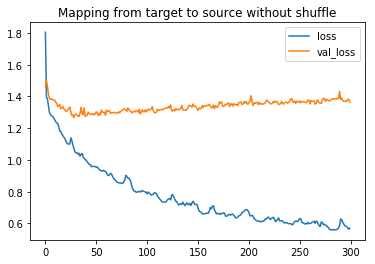

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Mapping from target to source without shuffle')
plt.legend()
plt.show()

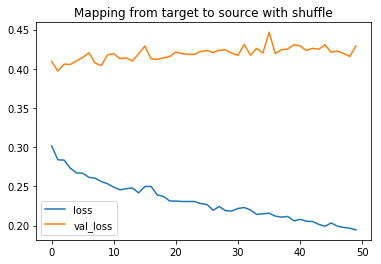

In [118]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Mapping from target to source with shuffle')
plt.legend()
plt.show()

#### Classification based on source top model

In [16]:
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

W1203 05:29:22.063322 139667848713984 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W1203 05:29:22.170773 139667848713984 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1203 05:29:22.837270 139667848713984 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1203 05:29:23.629728 139667848713984 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

In [17]:
input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-5,0):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i+6].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
s_topmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 736)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 31)                22847     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31)                124       
_________________________________________________________________
activation_1 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
_________________________________________________________________


In [25]:
input_model = Input(shape=(18,18,736))
x = encoder(input_model)
x = s_topmodel(x)

model = Model(input_model, x)

for layer in model.layers[1].layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0005), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
model_2 (Model)              (None, 18, 18, 736)       61294784  
_________________________________________________________________
model_3 (Model)              (None, 31)                22971     
Total params: 61,317,755
Trainable params: 22,909
Non-trainable params: 61,294,846
_________________________________________________________________


In [26]:
num_webcam_labels = [label_dict[k] for k in webcam_labels]
num_webcam_labels = keras.utils.to_categorical(num_webcam_labels, 31)

num_val_webcam_labels = [label_dict[k] for k in val_webcam_labels]
num_val_webcam_labels = keras.utils.to_categorical(num_val_webcam_labels, 31)

In [27]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/transform_feature_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

history = model.fit(t_features, num_webcam_labels, batch_size=16, epochs=200, 
                    validation_data=(t_val_features, num_val_webcam_labels), callbacks=[mcp])

Train on 444 samples, validate on 112 samples
Epoch 1/200
444/444 [==============================] - 1s 2ms/step - loss: 4.5118 - acc: 0.0383 - val_loss: 3.4716 - val_acc: 0.0446
Epoch 2/200
444/444 [==============================] - 0s 690us/step - loss: 4.3514 - acc: 0.0608 - val_loss: 3.4436 - val_acc: 0.0446
Epoch 3/200
444/444 [==============================] - 0s 697us/step - loss: 3.9162 - acc: 0.0563 - val_loss: 3.4730 - val_acc: 0.0357
Epoch 4/200
444/444 [==============================] - 0s 995us/step - loss: 3.8810 - acc: 0.0721 - val_loss: 3.4658 - val_acc: 0.0357
Epoch 5/200
444/444 [==============================] - 1s 1ms/step - loss: 3.7094 - acc: 0.1014 - val_loss: 3.4460 - val_acc: 0.0446
Epoch 6/200
444/444 [==============================] - 0s 825us/step - loss: 3.5881 - acc: 0.0923 - val_loss: 3.4345 - val_acc: 0.0893
Epoch 7/200
444/444 [==============================] - 0s 1ms/step - loss: 3.5070 - acc: 0.1374 - val_loss: 3.3963 - val_acc: 0.1071
Epoch 8/200
444

444/444 [==============================] - 0s 877us/step - loss: 2.7258 - acc: 0.2005 - val_loss: 2.7630 - val_acc: 0.2679
Epoch 62/200
444/444 [==============================] - 0s 917us/step - loss: 2.6320 - acc: 0.2432 - val_loss: 2.7532 - val_acc: 0.2679
Epoch 63/200
444/444 [==============================] - 0s 872us/step - loss: 2.6268 - acc: 0.2365 - val_loss: 2.7574 - val_acc: 0.2589
Epoch 64/200
444/444 [==============================] - 0s 887us/step - loss: 2.5567 - acc: 0.2748 - val_loss: 2.7648 - val_acc: 0.2589
Epoch 65/200
444/444 [==============================] - 0s 1ms/step - loss: 2.6430 - acc: 0.2342 - val_loss: 2.7536 - val_acc: 0.2768
Epoch 66/200
444/444 [==============================] - 0s 816us/step - loss: 2.6287 - acc: 0.2477 - val_loss: 2.7477 - val_acc: 0.2679
Epoch 67/200
444/444 [==============================] - 0s 697us/step - loss: 2.6421 - acc: 0.2275 - val_loss: 2.7426 - val_acc: 0.2768
Epoch 68/200
444/444 [==============================] - 0s 781u

Epoch 181/200
444/444 [==============================] - 0s 843us/step - loss: 2.3995 - acc: 0.2815 - val_loss: 2.5994 - val_acc: 0.3214
Epoch 182/200
444/444 [==============================] - 0s 784us/step - loss: 2.4017 - acc: 0.2793 - val_loss: 2.5941 - val_acc: 0.3304
Epoch 183/200
444/444 [==============================] - 0s 696us/step - loss: 2.4349 - acc: 0.2793 - val_loss: 2.6011 - val_acc: 0.3214
Epoch 184/200
444/444 [==============================] - 0s 979us/step - loss: 2.4354 - acc: 0.2860 - val_loss: 2.6055 - val_acc: 0.3393
Epoch 185/200
444/444 [==============================] - 0s 765us/step - loss: 2.3623 - acc: 0.2883 - val_loss: 2.6078 - val_acc: 0.3125
Epoch 186/200
444/444 [==============================] - 0s 916us/step - loss: 2.3864 - acc: 0.2860 - val_loss: 2.6162 - val_acc: 0.3304
Epoch 187/200
444/444 [==============================] - 0s 830us/step - loss: 2.3531 - acc: 0.3333 - val_loss: 2.6207 - val_acc: 0.3304
Epoch 188/200
444/444 [==================

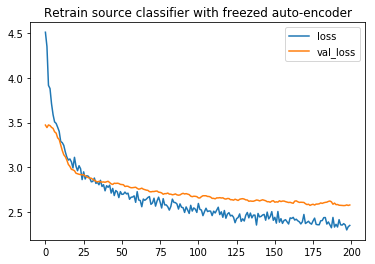

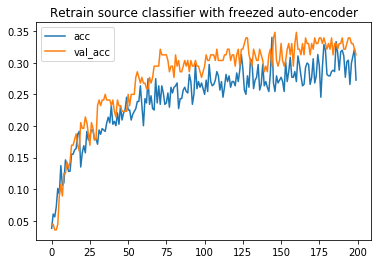

In [28]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Retrain source classifier with freezed auto-encoder')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.title('Retrain source classifier with freezed auto-encoder')
plt.legend()
plt.show()

In [66]:
test_model = load_model('/data/Quan/tf_models/webcam/transform_feature_model.hdf5')
test_model.evaluate(t_test_features, t_test_labels, verbose=1)

#webcam acc: 0.73

239/239 [==============================] - 1s 4ms/step


[1.583292324672683, 0.6443514645598424]

In [323]:
t_test_paths = get_image_paths('/data/Quan/datasets/webcam/test_images')

t_test_images = [resize(imread(k), (300,300)) for k in t_test_paths]
t_test_images = np.asarray(t_test_images)

t_test_labels = np.array([k.split('/')[-2] for k in t_test_paths])

In [324]:
t_test_labels = [label_dict[k] for k in t_test_labels]
t_test_labels = keras.utils.to_categorical(t_test_labels, num_classes=31)
t_test_labels.shape

(239, 31)

In [307]:
t_test_features = pretrain_amazon.predict(t_test_images, verbose=1)
t_test_features.shape

239/239 [==============================] - 1s 5ms/step


(239, 18, 18, 736)

In [308]:
with open('/data/Quan/tf_models/webcam/t_test_features.hdf5', 'wb') as dt:
    pickle.dump([t_test_labels, t_test_features],dt)

In [24]:
with open('/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    t_test_labels, t_test_features = pickle.load(dt)
    
t_test_labels = [label_dict[k] for k in t_test_labels]
t_test_labels = keras.utils.to_categorical(t_test_labels, 31)
t_test_labels = np.asarray(t_test_labels)

In [19]:
encoder = load_model('/data/Quan/tf_models/webcam/encoder_model.hdf5')

In [310]:
t_transformed_features = encoder.predict(t_test_features, verbose=1)
t_transformed_features.shape

239/239 [==============================] - 2s 7ms/step


(239, 18, 18, 736)

In [23]:
label_dict = test_generator.class_indices

In [48]:
amazon_labels = get_image_paths('/data/Quan/datasets/amazon/images')
amazon_labels = [k.split('/')[-2] for k in amazon_labels]
amazon_labels = np.asarray(amazon_labels)

webcam_labels = [k.split('/')[-2] for k in webcam_paths]
webcam_labels = np.asarray(webcam_labels)

In [161]:
val_amazon_labels = get_image_paths('/data/Quan/datasets/amazon/val_images')
val_amazon_labels = [k.split('/')[-2] for k in val_amazon_labels]
val_amazon_labels = np.asarray(val_amazon_labels)

val_webcam_labels = [k.split('/')[-2] for k in val_webcam_paths]
val_webcam_labels = np.asarray(val_webcam_labels)

In [122]:
for l in np.unique(webcam_labels):
    print(len(np.where(webcam_labels==l)[0]))

14
14
10
9
8
15
27
12
10
12
16
19
17
8
16
27
13
17
12
16
10
14
19
17
21
6
13
18
15
8
11


In [46]:
amazon_labels = np.asarray(amazon_labels)

In [60]:
np.where(amazon_labels=='headphones')[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56])

In [9]:
import shutil

os.mkdir('/data/Quan/datasets/webcam/val_images')

for i in range(len(test_paths)):
    if not os.path.isdir(os.path.join('/data/Quan/datasets/webcam/val_images',test_labels[i])):
        os.mkdir(os.path.join('/data/Quan/datasets/webcam/val_images',test_labels[i]))
   
    shutil.move(test_paths[i], os.path.join('/data/Quan/datasets/webcam/val_images', test_labels[i], os.path.basename(test_paths[i])))

In [32]:
import shutil

# os.mkdir('/data/Quan/datasets/amazon/test_images')

for i in range(len(test_paths)):
    if not os.path.isdir(os.path.join('/data/Quan/datasets/amazon/test_images',test_labels[i])):
        os.mkdir(os.path.join('/data/Quan/datasets/amazon/test_images',test_labels[i]))
   
    shutil.move(test_paths[i], os.path.join('/data/Quan/datasets/amazon/test_images', test_labels[i], os.path.basename(test_paths[i])))